In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.8 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import rasterio
import cv2
import glob
import os

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 3163s 50s/step - accuracy: 0.9227 - dice_coefficient: 0.3676 - loss: 0.4531 - val_accuracy: 1.0000 - val_dice_coefficient: 0.9996 - val_loss: 0.2191
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 3086s 49s/step - accuracy: 1.0000 - dice_coefficient: 0.9993 - loss: 0.2074 - val_accuracy: 1.0000 - val_dice_coefficient: 0.9971 - val_loss: 0.1754
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 3109s 49s/step - accuracy: 1.0000 - dice_coefficient: 0.9997 - loss: 0.1668 - val_accuracy: 1.0000 - val_dice_coefficient: 0.9840 - val_loss: 0.1434


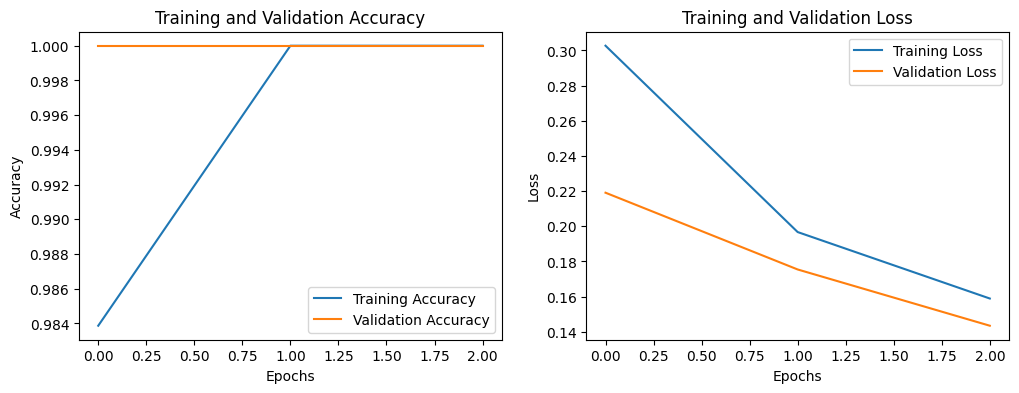

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


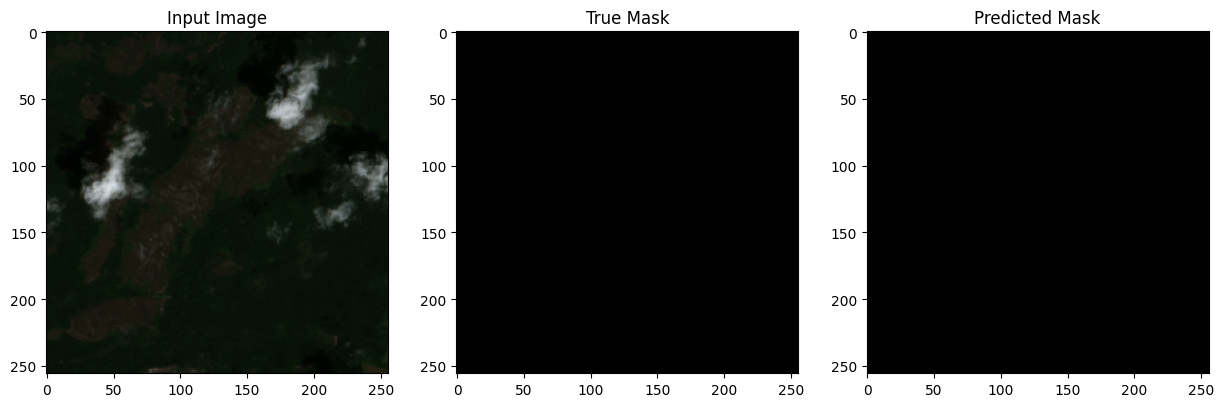

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


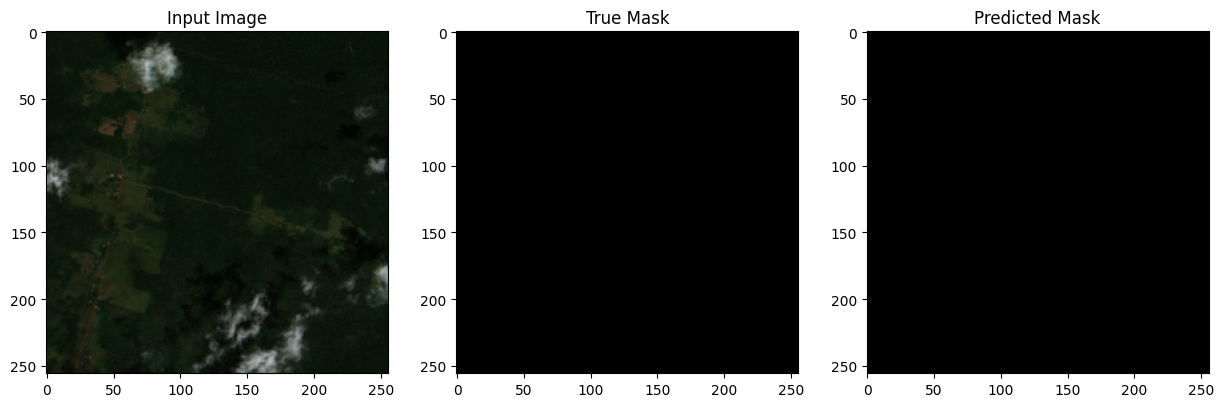

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import cv2
# Import the Keras backend
from tensorflow import keras
# Assign it to a variable named K for easier use
K = keras.backend

def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Cast y_true_f to float32 to match the type of y_pred_f
    y_true_f = K.cast(y_true_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Define U-Net Model for Semantic Segmentation with Regularization
def unet_model(input_size=(256, 256, 4)):
    inputs = Input(input_size)

    # Encoding Path
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.3)(pool1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.3)(pool2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.3)(pool3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(conv4)
    conv4 = Dropout(0.5)(conv4)

    # Decoding Path
    up5 = UpSampling2D(size=(2, 2))(conv4)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(merge5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(merge6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(merge7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(conv7)

    conv8 = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=conv8)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient])

    return model

# Load and Preprocess Dataset with Resizing
def load_data(image_paths, mask_paths, target_size=(256, 256)):
    images = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load GeoTIFF image
        with rasterio.open(img_path) as src:
            image = src.read()
            image = np.transpose(image, (1, 2, 0))  # Reorder dimensions to (height, width, channels)
            image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)  # Resize image
            image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        # Load Mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)  # Resize mask
        mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)[1]  # Binarize mask

        images.append(image)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)  # Add channel dimension to masks

    return images, masks

# Paths to Dataset (adjust paths as needed)
train_image_folder = "/content/drive/MyDrive/folder/AMAZON-1/Training/image/"
train_mask_folder = "/content/drive/MyDrive/folder/AMAZON-1/Training/label/"

validation_image_folder = "/content/drive/MyDrive/folder/AMAZON-1/Validation/images/"
validation_mask_folder = "/content/drive/MyDrive/folder/AMAZON-1/Validation/masks/"

# Get all image and mask paths
train_image_paths = sorted(glob.glob(train_image_folder + "/*.tif"))
train_mask_paths = sorted(glob.glob(train_mask_folder + "/*.tif"))

validation_image_paths = sorted(glob.glob(validation_image_folder + "/*.tif"))
validation_mask_paths = sorted(glob.glob(validation_mask_folder + "/*.tif"))

# Load Training and Validation Data
X_train, y_train = load_data(train_image_paths, train_mask_paths, target_size=(256, 256))
X_val, y_val = load_data(validation_image_paths, validation_mask_paths, target_size=(256, 256))

# Data Augmentation for Training Data
data_gen_args = dict(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen = ImageDataGenerator(**data_gen_args)
train_generator = train_datagen.flow(X_train, y_train, batch_size=8)

# Train the Model with Augmentation and Save Training History
model = unet_model(input_size=(256, 256, 4))
history = model.fit(train_generator, validation_data=(X_val, y_val), epochs=3, verbose=1)

# Save the Model
model.save('forest_segmentation_amazon.h5')

# Save Training History
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)

# Visualization of Training History
def plot_training_history(history_data):
    plt.figure(figsize=(12, 4))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_data['accuracy'], label='Training Accuracy')
    plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(history_data['loss'], label='Training Loss')
    plt.plot(history_data['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Load Training History and Plot
with open('training_history.json', 'r') as f:
    history_data = json.load(f)

plot_training_history(history_data)

# Additional Visualizations (Confusion Matrix and Sample Predictions)
def plot_sample_predictions(model, X_val, y_val, num_samples=3):
    for i in range(num_samples):
        sample_image = X_val[i]
        true_mask = y_val[i]
        predicted_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        plt.imshow(sample_image[:, :, :3])  # Display RGB channels

        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(true_mask[:, :, 0], cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(predicted_mask[:, :, 0], cmap='gray')

        plt.show()

# Plot Sample Predictions
plot_sample_predictions(model, X_val, y_val, num_samples=3)

